In [5]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yfinance as yf
import scipy.optimize as sco
import investpy
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib as mpl


In [3]:
!pip install yfinance
!pip install investpy

     |████████████████████████████████| 4.4 MB 441 kB/s eta 0:00:01     |████████████████████▏           | 2.8 MB 717 kB/s eta 0:00:03     |███████████████████████████     | 3.7 MB 441 kB/s eta 0:00:02
     |████████████████████████████████| 238 kB 3.5 MB/s eta 0:00:01
  Created wheel for investpy: filename=investpy-0.9.14-py3-none-any.whl size=4469456 sha256=e2e2854b1331fd91041c918da0eacc4173bf9c5887c12b2e9c9338484cf2602f
  Stored in directory: /home/nikdim/.cache/pip/wheels/95/6b/b3/e3633d50b8f3f5c5a86631db8010cdbca29ac99772ecf302f7
Successfully built investpy


First, we complete an online questionnaire to ascertain our risk aversion. Such questionnaires provide a suggested allocation to stocks and bonds. Some even extend their analysis to commodities. After we select the allocation of assets we select our instruments. We have opted for 6 stocks, 2 bonds and 2 commodities for a total of 10 assets. The selection of each asset is up to the investor. Here, the focus is on diversification and the analysis spans the last five years.

In [6]:
# portfolio allocation for stocks, bonds and commodities respectively
ss, bb, cc = 0.7, 0.2, 0.1

# instrument selection
stocks = ['AVGO','NOW', 'TSLA', 'AMZN', 'IRDM', 'BR']
bonds = ['PYACX', 'SIGAX']
commodities = ['gold','palladium']

rf = 2.27
sp500 = ['S&P 500']

assets = stocks + bonds + commodities + sp500
print(assets)

['AVGO', 'NOW', 'TSLA', 'AMZN', 'IRDM', 'BR', 'PYACX', 'SIGAX', 'gold', 'palladium', 'S&P 500']


In [7]:
d = datetime.datetime(2020, 1, 13) - relativedelta(years=5)
from_date = str(d.day) + '/' + str(d.month) + '/' + str(d.year)

d = datetime.datetime(2020, 1, 13)
to_date = str(d.day) + '/' + str(d.month) + '/' + str(d.year)

s1 = investpy.stocks.get_stock_historical_data(stock=stocks[0], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s2 = investpy.stocks.get_stock_historical_data(stock=stocks[1], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s3 = investpy.stocks.get_stock_historical_data(stock=stocks[2], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s4 = investpy.stocks.get_stock_historical_data(stock=stocks[3], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s5 = investpy.stocks.get_stock_historical_data(stock=stocks[4], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s6 = investpy.stocks.get_stock_historical_data(stock=stocks[5], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

benchmark = investpy.indices.get_index_historical_data(index='S&P 500', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

b1 = investpy.funds.get_fund_historical_data(fund='Payden Corporate Bond Fund', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
b2 = investpy.funds.get_fund_historical_data(fund='Western Asset Corporate Bond Fund Class A', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

c1 = investpy.commodities.get_commodity_historical_data(commodity=commodities[0],from_date=from_date, to_date=to_date, interval='Daily')['Close']
c2 = investpy.commodities.get_commodity_historical_data(commodity=commodities[1],from_date=from_date, to_date=to_date, interval='Daily')['Close']

In [8]:
# Place the DataFrames side by side
s = pd.concat([s1, s2, s3, s4, s5, s6], axis=1)
s.columns = stocks

b = pd.concat([b1, b2], axis=1)
b.columns = bonds

c = pd.concat([c1, c2, benchmark], axis=1)
c.columns = commodities + sp500

In [9]:
data = pd.concat([s, b, c], axis=1)
data = data.dropna()
data.head()

,AVGO,NOW,TSLA,AMZN,IRDM,BR,PYACX,SIGAX,gold,palladium,S&P 500
Date,,,,,,,,,,,
2015-01-13,102.58,67.27,204.25,294.74,9.32,46.78,11.22,12.46,1234.3,815.70,2023.03
2015-01-14,103.39,66.34,192.69,293.27,9.12,46.39,11.23,12.45,1234.4,780.65,2011.27
2015-01-15,101.32,63.63,191.87,286.95,8.63,45.94,11.27,12.46,1264.7,766.35,1992.67
2015-01-16,103.82,63.96,193.07,290.74,8.84,46.76,11.23,12.43,1276.9,754.30,2019.42
2015-01-20,104.87,64.83,191.93,289.44,9.11,46.50,11.26,12.45,1294.2,778.75,2022.55


In [11]:
daily_returns = data.pct_change()[1:]*100

print(daily_returns)

                AVGO       NOW      TSLA      AMZN      IRDM        BR  \
Date                                                                     
2015-01-14  0.789628 -1.382488 -5.659731 -0.498745 -2.145923 -0.833690   
2015-01-15 -2.002128 -4.085017 -0.425554 -2.155011 -5.372807 -0.970037   
2015-01-16  2.467430  0.518623  0.625423  1.320788  2.433372  1.784937   
2015-01-20  1.011366  1.360225 -0.590459 -0.447135  3.054299 -0.556031   
2015-01-21  0.486316  1.064322  2.417548  2.698314  0.000000  0.107527   
...              ...       ...       ...       ...       ...       ...   
2020-01-07 -0.344256  0.013658  3.880055  0.209157 -1.797125 -0.352000   
2020-01-08 -1.247441  0.935441  4.920479 -0.780865 -0.366002  0.642261   
2020-01-09 -0.803265  1.237950 -2.194498  0.479923  1.469388  2.185705   
2020-01-10 -2.298700 -0.143664 -0.662733 -0.941059 -0.040225 -0.398126   
2020-01-13  0.655036  1.662875  9.768901  0.432252  2.575453  0.705384   

               PYACX     SIGAX      g

C:\Users\apost\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


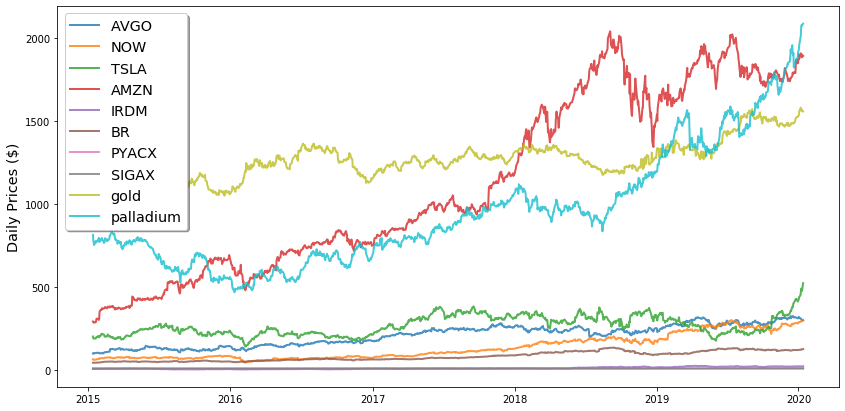

In [7]:
# plot historical prices for all assets
plt.figure(figsize=(14, 7))
for c in data.columns[:-1].values:
    plt.plot(data.index, data[c], lw=2, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize='x-large',shadow=True)
plt.ylabel('Daily Prices ($)', fontsize='x-large')

Text(0, 0.5, 'Daily Prices ($)')

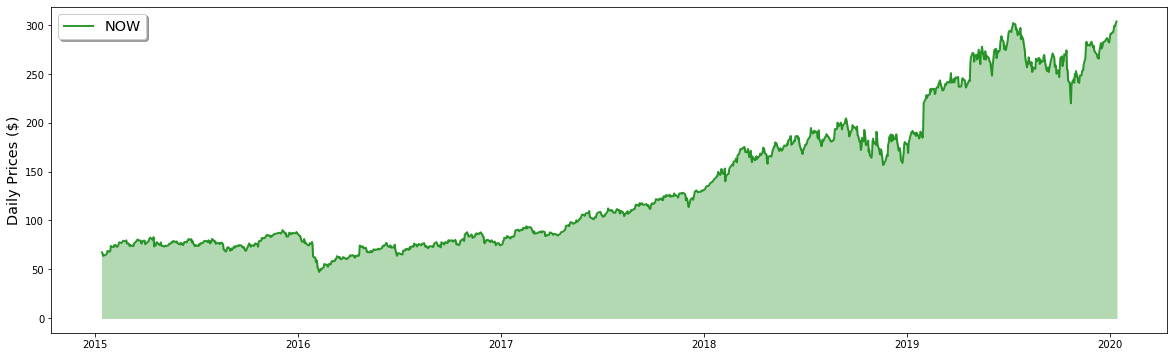

In [15]:
# "Yahoo-Finance style" plot 
sec = 'NOW'
mix=0.7
primary_color = 'green'
plt.figure(figsize=(20,6))
plt.plot(data[sec], lw=2, alpha=0.8,label=sec,color=primary_color)
plt.legend(loc='upper left', fontsize='x-large',shadow=True)
c1=np.array(mpl.colors.to_rgb(primary_color))
c2=np.array(mpl.colors.to_rgb('white'))
plt.fill_between(data[sec].index, data[sec].values,color=mpl.colors.to_hex((1-mix)*c1 + mix*c2))
plt.ylabel('Daily Prices ($)', fontsize='x-large')

## Descriptive Statistics

Descriptive statistics are broken down into measures of central tendency and measures of variability (spread). Measures of central tendency include the mean, median, and mode, while measures of variability include the standard deviation, variance, the minimum and maximum variables, and the kurtosis and skewness.

In [16]:
q4 = ['mean (%)','median (%)','std (%)','var (%)','min (%)','max (%)','kurtosis','skewness']
q5 = ['alpha','beta','R-squared']

In [17]:
df = pd.DataFrame(columns= q4+q5,index=assets)

In [39]:
import statistics
import scipy.stats

x = daily_returns[assets[-1]].values
rf_daily = (np.power((1+(rf/100)),(1/252)) - 1) * 100
x = x - rf_daily

for i in range(len(assets)):
    # fetch returns for asset i
    l = daily_returns[assets[i]].tolist()
    # compute descriptive statistics for instrument i
    df.iloc[i]['mean (%)'] = statistics.mean(l)
    df.iloc[i]['median (%)'] = statistics.median(l)
    df.iloc[i]['std (%)'] = statistics.stdev(l)
    df.iloc[i]['var (%)'] = statistics.variance(l)
    df.iloc[i]['min (%)'] = min(l)
    df.iloc[i]['max (%)'] = max(l)
    df.iloc[i]['kurtosis'] = scipy.stats.kurtosis(l)
    df.iloc[i]['skewness'] = scipy.stats.skew(l)
    
    y = daily_returns[assets[i]].values - rf_daily
    
    # compute alpha, beta, r-squared for instrument i
    (beta, alpha, r_value) = scipy.stats.linregress(x,y)[0:3]
    df.iloc[i]['alpha'] = (np.power((1 + (alpha/100)), 252) - 1)
    df.iloc[i]['beta'] = beta
    df.iloc[i]['R-squared'] = r_value ** 2
  
# print df
df.T

,AVGO,NOW,TSLA,AMZN,IRDM,BR,PYACX,SIGAX,gold,palladium,S&P 500
mean (%),0.107166,0.145902,0.116156,0.166039,0.115048,0.0891013,0.00433104,0.00341559,0.0237899,0.089933,0.0425348
median (%),0.111262,0.206555,0.0604412,0.137357,0.118483,0.0910391,0,0,0,0.150464,0.0503795
std (%),2.04098,2.22672,2.85081,1.84799,2.6336,1.26773,0.267192,0.228246,0.988315,1.70887,0.844989
var (%),4.1656,4.95827,8.1271,3.41508,6.93584,1.60714,0.0713917,0.0520964,0.976766,2.92022,0.714007
min (%),-13.7447,-15.6561,-13.9015,-7.81968,-11.1297,-9.70149,-2.07769,-1.28928,-4.31929,-7.40462,-4.09792
max (%),14.7054,14.0685,17.6692,14.1311,22.2393,11.1618,0.771208,0.668338,5.09752,7.28252,4.95938
kurtosis,5.30694,6.50428,5.06032,9.82735,6.47356,9.28693,3.40086,1.28455,4.5533,1.49086,3.8721
skewness,0.234287,-0.331896,0.302733,1.00681,0.623741,-0.187851,-0.708179,-0.434499,0.328708,-0.147156,-0.468768
alpha,0.142129,0.247185,0.177113,0.328149,0.15867,0.132064,-0.00576098,-0.0121462,0.0516155,0.178173,0
beta,1.35333,1.46614,1.26445,1.32199,1.41795,0.920635,-0.0679181,-0.0191122,-0.151393,0.47398,1


Text(2019-1-14, 370, 'Cybertruck \n announcement')

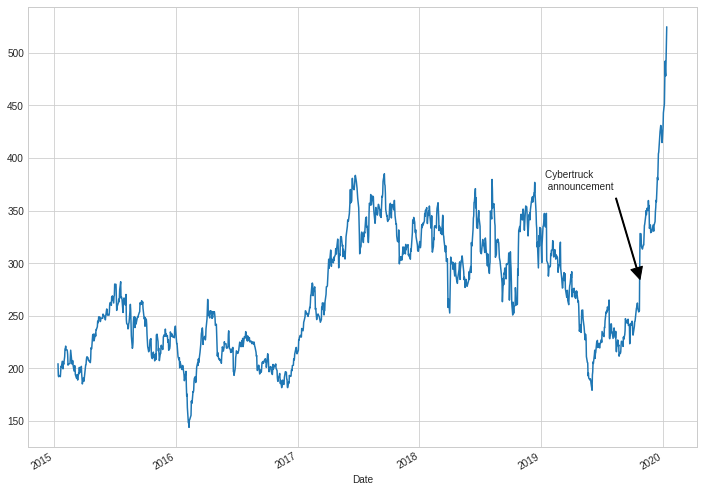

In [19]:
# Annotated graph for minimum and maximum
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(12, 9))
data['TSLA'].plot(ax=ax)

style = dict(size=10, color='black')
# ax.text('2019-1-14', 370, "Cybertruck \n announcement", **style)
ax.annotate('Cybertruck \n announcement', xy=('2019-10-29', 280), xytext=('2019-1-14', 370),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1))

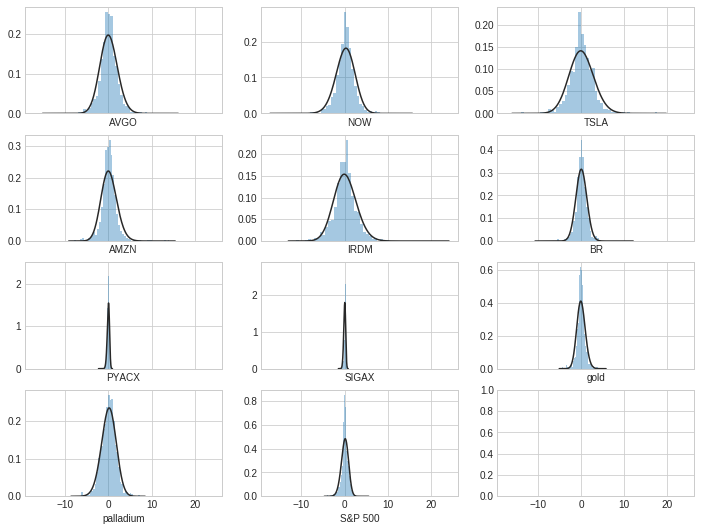

In [20]:
# plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(4,3,figsize=(12, 9), sharex=True)
for i in range(len(assets)):
    sns.distplot(daily_returns[assets[i]],fit=scipy.stats.skewnorm, kde=False, ax=ax[i//3, np.mod(i,3)])

## Question 5
<span style="color:blue">Compute additional metrics for the assets such as the correlation and covariance matrices, for the entire and two subperiods (of your own choosing), if needed. Interpret your findings. Also, compute each fund’s alpha, beta, R-square. Interpret your findings from the perspective of the investor.</span>

(11.5, -0.5)

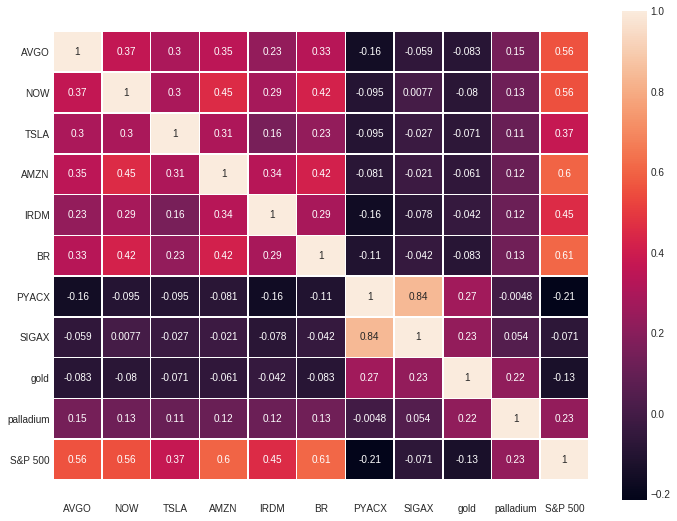

In [21]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(daily_returns.corr(), annot=True,  linewidths=.5, ax=ax)
plt.yticks(rotation=0)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Question 6
<span style="color:blue">Calculate the return/risk of your risky portfolio. Explain each step in your analysis. You must use EXCEL’s mmult functions for this part of the analysis.</span>

In [26]:
# discard the benchmark (S&P500)
selected = assets[:-1]
table = data[assets[:-1]]

# calculate daily and annual returns of the assets
returns_daily = data[assets[:-1]].pct_change()[1:] * 100
returns_annual = (np.power((1 + (returns_daily.mean()/100)), 252) - 1) * 100

# get daily covariance of returns of the stock
cov_daily = (returns_daily/100).cov()

# Calculate Risk/Return of a naive portfolio
s = [ss/len(stocks) for _ in range(len(stocks))]
b = [bb/len(bonds) for _ in range(len(bonds))]
c = [cc/len(commodities) for _ in range(len(commodities))]
weights =  np.hstack((s,b,c))
weights_naive = weights / np.sum(weights)

returns_naive = np.dot(weights_naive, returns_annual)
volatility_naive = np.sqrt(np.dot(weights_naive.T, np.dot(cov_daily, weights_naive))) * np.sqrt(252) * 100
beta_naive = np.dot(weights_naive, df['beta'].to_numpy()[:-1])
sharpe_naive = (returns_naive - rf)/(volatility_naive)

print(returns_naive)
print(volatility_naive)
print(beta_naive)
print(sharpe_naive)

27.44774143679671
15.756861066285893
0.9109510282910608
1.5978906795509018


## Question 7
<span style="color:blue">Derive and graph the Capital Allocation Line. Graph the Efficient Frontier with your available investment instruments (assets) and superimpose your CAL. Discuss the various options you may have and finalize your optimal point.</span>

In [27]:
# produce random weight vector with stock/bond/commodity fixed allocation
def random_weights():
    s = np.random.random(len(stocks))
    s = s / np.sum(s)
    s = ss * s
    b = np.random.random(len(bonds))
    b = b / np.sum(b)
    b = bb * b
    c = np.random.random(len(commodities))
    c = c / np.sum(c)
    c = cc * c
    weights =  np.hstack((s,b,c))
    return weights

In [33]:
# empty lists to store returns, volatility and weights of imaginary portfolios
port_returns = []
port_volatility = []
port_sharpe_ratio = []
port_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 200000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = random_weights()
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_daily, weights))) * np.sqrt(252) * 100
    
    # store the return, volatility, Sharpe ratio and weights for this imaginary portfolio
    port_returns.append(returns)
    port_sharpe_ratio.append((returns - rf)/volatility)
    port_volatility.append(volatility)
    port_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': port_sharpe_ratio
            }

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in port_weights]

# make a nice dataframe of the extended dictionary
df_ef = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility','Sharpe Ratio'] + [asset+' Weight' for asset in selected]

# reorder dataframe columns
df_ef = df_ef[column_order]

df_ef

,Returns,Volatility,Sharpe Ratio,AVGO Weight,NOW Weight,TSLA Weight,AMZN Weight,IRDM Weight,BR Weight,PYACX Weight,SIGAX Weight,gold Weight,palladium Weight
0,27.771234,16.645115,1.532055,0.100126,0.146245,0.090758,0.129338,0.192154,0.041379,0.189083,0.010917,0.097695,0.002305
1,27.183805,15.519818,1.605290,0.058878,0.110065,0.127751,0.125727,0.124024,0.153554,0.160336,0.039664,0.061259,0.038741
2,28.548601,17.233608,1.524846,0.172695,0.099222,0.180050,0.160452,0.080039,0.007541,0.159445,0.040555,0.066850,0.033150
3,26.998924,16.463625,1.502034,0.111021,0.215913,0.147619,0.045542,0.033826,0.146078,0.108395,0.091605,0.049912,0.050088
4,32.309720,18.113130,1.658450,0.055093,0.314760,0.067849,0.241482,0.010475,0.010340,0.088903,0.111097,0.081045,0.018955
...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,24.534147,15.538385,1.432848,0.174127,0.081995,0.126162,0.032932,0.132369,0.152414,0.057209,0.142791,0.078500,0.021500
199996,27.840963,16.328148,1.566066,0.057043,0.158802,0.086474,0.075395,0.164061,0.158226,0.091665,0.108335,0.003162,0.096838
199997,27.882462,16.275233,1.573708,0.075894,0.122030,0.126915,0.125755,0.153653,0.095752,0.125510,0.074490,0.054307,0.045693
199998,27.493252,15.858677,1.590502,0.052278,0.152571,0.155179,0.094065,0.027624,0.218282,0.183208,0.016792,0.012210,0.087790


1.8501722492837238
[ 5.79358449 10.43542004  0.98484455 33.44023161  2.05547164 17.29044767
 12.17710645  7.82289355  2.96074508  7.03925492]


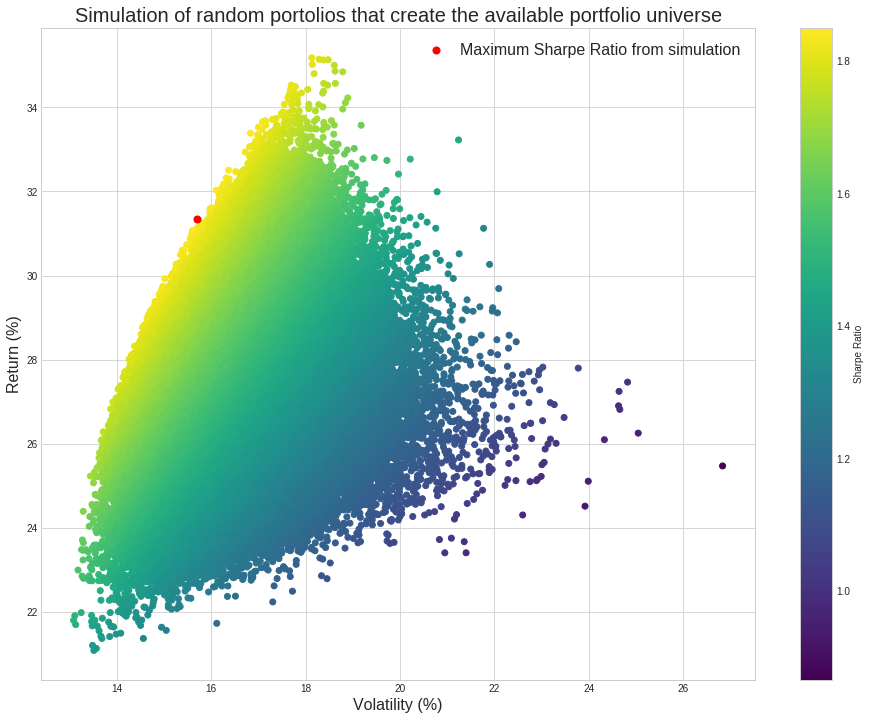

In [34]:
# the optimal risky portfolio has the highest Sharpe Ratio
id = df_ef['Sharpe Ratio'].idxmax()
max_sr_vol, max_sr_ret = df_ef['Volatility'][id], df_ef['Returns'][id]

max_sr = df_ef['Sharpe Ratio'].max()

print(max_sr)

optimal_weights = port_weights[id]

print(optimal_weights*100)

fig, ax = plt.subplots(figsize=(16, 12))

plt.scatter(df_ef['Volatility'], df_ef['Returns'], c=df_ef['Sharpe Ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=50, label='Maximum Sharpe Ratio from simulation') # red dot

ax.set_title('Simulation of random portolios that create the available portfolio universe', fontsize=20)
ax.set_xlabel('Volatility (%)', fontsize=16)
ax.set_ylabel('Return (%)', fontsize=16)
ax.legend(labelspacing=0.8,shadow=True, handlelength=1.5, fontsize=16)

---
---
---
---
---
---


To plot the Efficient Frontier, an array of optimization problems must be solved.

In [35]:
def portfolio_volatility(weights, cov_daily):
    return (np.sqrt(np.dot(weights.T, np.dot(cov_daily, weights))) * np.sqrt(252) * 100)

def efficient_return(returns_annual, cov_daily, target):
    num_assets = len(returns_annual)
    args = (cov_daily)

    def portfolio_return(weights):
        return np.dot(weights, returns_annual)

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sum(x[:len(stocks)]) - ss},
                   {'type': 'eq', 'fun': lambda x: np.sum(x[-len(commodities):]) - cc}
                  )
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


# def efficient_frontier(returns_annual, cov_daily, returns_range):
#     efficients = []
#     for ret in returns_range:
#         efficients.append(efficient_return(returns_annual, cov_daily, ret))
#     return efficients
def efficient_frontier(returns_annual, cov_daily, returns_range):
    return [efficient_return(returns_annual, cov_daily, ret) for ret in returns_range]

In [36]:
# Find the EF
targets = np.linspace(df_ef['Returns'].min(), df_ef['Returns'].max(), 1000)
efficient_portfolios = efficient_frontier(returns_annual, cov_daily, targets)

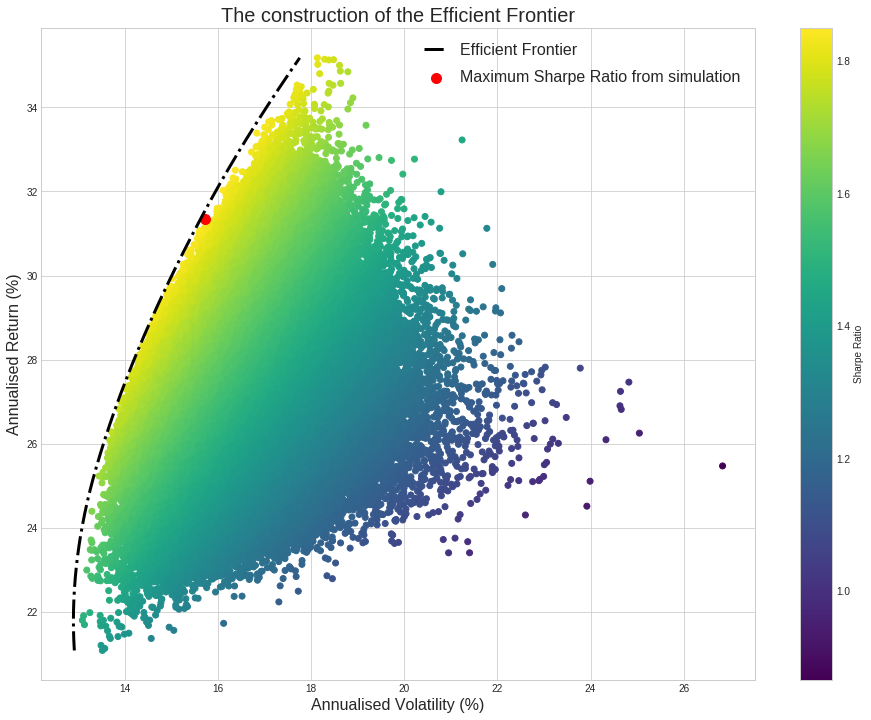

In [37]:
# Graph that includes:
#     1. the Random Portfolios
#     2. The Efficient Frontier
#     3. The Optimal Risky Portfolio from Simulation
fig, ax = plt.subplots(figsize=(16, 12))

# plot (1) the Random Portfolios
plt.scatter(df_ef['Volatility'], df_ef['Returns'], c=df_ef['Sharpe Ratio'], cmap='viridis')
cbar = plt.colorbar(label='Sharpe Ratio')

# plot (2) The Efficient Frontier
ax.plot([p['fun'] for p in efficient_portfolios], targets, linestyle='-.',lw=3, color='black', label='Efficient Frontier')

# plot (3) the Optimal Risky Portfolio from Simulation
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100, label='Maximum Sharpe Ratio from simulation') 

# title, axes and legend
ax.set_title('The construction of the Efficient Frontier', fontsize=20)
ax.set_xlabel('Annualised Volatility (%)', fontsize=16)
ax.set_ylabel('Annualised Return (%)', fontsize=16)
ax.legend(labelspacing=0.8,shadow=True, handlelength=1.5, fontsize=16)

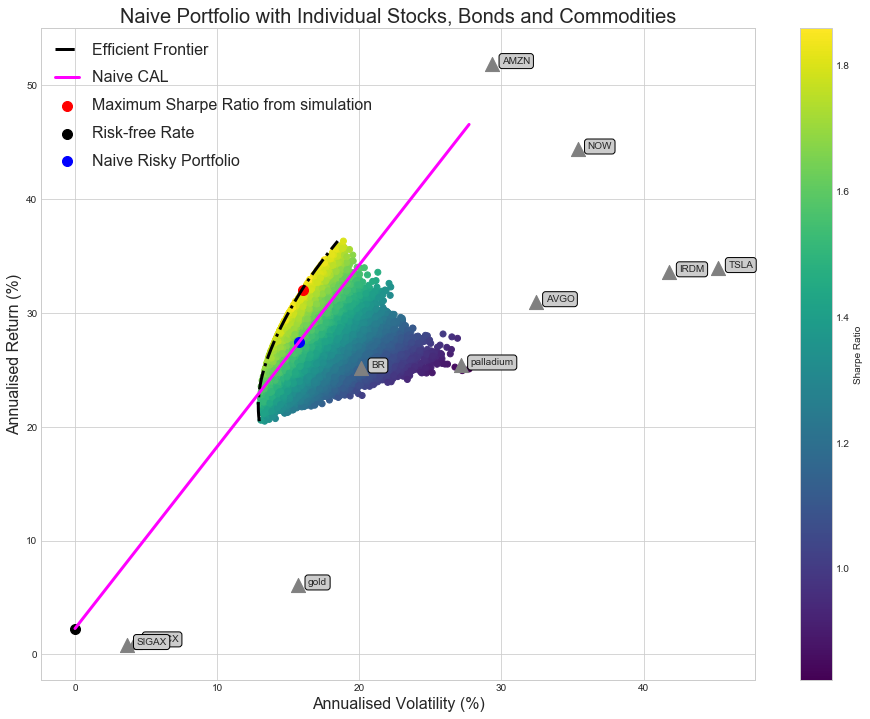

In [32]:
# Final graph that includes:
#     1. the random portfolios
#     2. The efficient frontier
#     3. The optimal risky Portfolio from simulation
#     4. the risk-free portfolio
#     5. The individual instruments
#     6. the naive portfolio
#     7. the CAL of the naive portfolio

fig, ax = plt.subplots(figsize=(16, 12))

# plot (1) the random portfolios
plt.scatter(df_ef['Volatility'], df_ef['Returns'], c=df_ef['Sharpe Ratio'], cmap='viridis')
cbar = plt.colorbar(label='Sharpe Ratio')

# plot (2) The Efficient Frontier
ax.plot([p['fun'] for p in efficient_portfolios], targets, linestyle='-.',lw=3, color='black', label='Efficient Frontier')

# plot (3) the Optimal Risky Portfolio from simulation
plt.scatter(max_sr_vol, max_sr_ret,c='red', s=100, label='Maximum Sharpe Ratio from simulation') 

# plot (4) the risk-free portfolio
plt.scatter(0, rf,c='black', s=100, label='Risk-free Rate') 

# plot (5) the individual instruments
vol = returns_daily.std() * np.sqrt(252)

# plot (6) the naive portfolio
plt.scatter(volatility_naive, returns_naive,c='blue',s=100, label='Naive Risky Portfolio') 

# plot (7) the CAL of the naive portfolio
x = np.linspace(0, df_ef['Volatility'].max(), 1000)
y = x * (returns_naive-rf)/volatility_naive + rf
ax.plot(x,y, label='Naive CAL', lw=3,color='magenta')


ax.scatter(vol,returns_annual,marker='^',s=200,color='gray')
for i in range(len(assets)-1):
        ax.annotate(df.index.values[i], 
                   (vol[i],returns_annual[i]), 
                    xytext=(10,0), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.8"))
    

# title, axes and legend
ax.set_title('Naive Portfolio with Individual Stocks, Bonds and Commodities', fontsize=20)
ax.set_xlabel('Annualised Volatility (%)', fontsize=16)
ax.set_ylabel('Annualised Return (%)', fontsize=16)
ax.legend(labelspacing=0.8,shadow=True, handlelength=1.5, fontsize=16)

## Question 9
<span style="color:blue">Measure and evaluate your overall portfolio’s performance and compare it with the passive investment strategy. In this step, you should apply EXCEL’s Solver to evaluate several possible outcomes (in terms of risk and return) and explain each outcome. In that endeavor, compute the various performance measures we have learned. Decide on the best outcome for you. Discuss.</span>

In [33]:
def max_sr(weights, returns_annual, cov_daily, rf):
    return -(np.dot(weights, returns_annual) - rf)/(np.sqrt(np.dot(weights.T, np.dot(cov_daily, weights))) * np.sqrt(252) * 100)

def optimal_point(returns_annual, cov_daily, rf):
    num_assets = len(returns_annual)
    args = (returns_annual, cov_daily, rf)

    def portfolio_return(weights):
        return np.dot(weights, returns_annual)

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.sum(x[:len(stocks)]) - ss},
                   {'type': 'eq', 'fun': lambda x: np.sum(x[-len(commodities):]) - cc}
                  )
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(max_sr, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [34]:
#Find the optimal sharpe ratio of the EF

optimal_sharpe_ratio = optimal_point(returns_annual, cov_daily, rf)

print(-optimal_sharpe_ratio['fun'])

opt_weights = optimal_sharpe_ratio['x']

opt_vol = np.sqrt(np.dot(opt_weights.T, np.dot(cov_daily, opt_weights))) * np.sqrt(252) * 100
opt_ret = np.dot(opt_weights, returns_annual)

opt_beta = np.dot(opt_weights, df['beta'].to_numpy()[:-1])

market_returns = (np.power((1 + (df.iloc[-1]['mean (%)']/100)), 252) - 1) * 100
market_vol = daily_returns['S&P 500'].std() * np.sqrt(252)
sharpe_ratio_market = (market_returns - rf)/(market_vol)

print((opt_weights*100).round(4))
print(opt_ret.round(4))
print(opt_vol.round(4))
print(opt_beta.round(4))
print(market_returns.round(4))
print(market_vol.round(4))
print(sharpe_ratio_market.round(4))

1.865754120485262
[ 4.0068  8.6743  1.0266 38.2827  1.32   16.6897 20.      0.      0.
 10.    ]
32.7164
16.3185
0.9067
11.3118
13.4138
0.6741


At this point we have finalized the optimal risky portfolio. The last step is to find the optimal overall portfolio, based on our level of risk-aversion, as measured by coefficient of risk-aversion A. Since we are risk-tolerant and young investors, we assume A = 1.5.We are searching for the optimal allocation between risk-free and risky assets:

In [35]:
A = 1.5
optimal_z = 0.95

# Optimal allocation of assets

A = (opt_ret - rf) / (0.1 * optimal_z * (opt_vol ** 2))

print(A) #this is number format

optimal_overall_return = rf + optimal_z * (opt_ret - rf)

optimal_overall_volatility = optimal_z * opt_vol

optimal_utility = (rf) + ((opt_ret) - (rf))*optimal_z - 0.05 * A * (optimal_z ** 2)*((opt_vol)**2) 

print(optimal_utility)

utility_x = np.linspace(0, 25, 1000)

utility_y = (optimal_utility + 0.05 * A * ((utility_x) ** 2))

1.2035098926874235
16.73202669067645


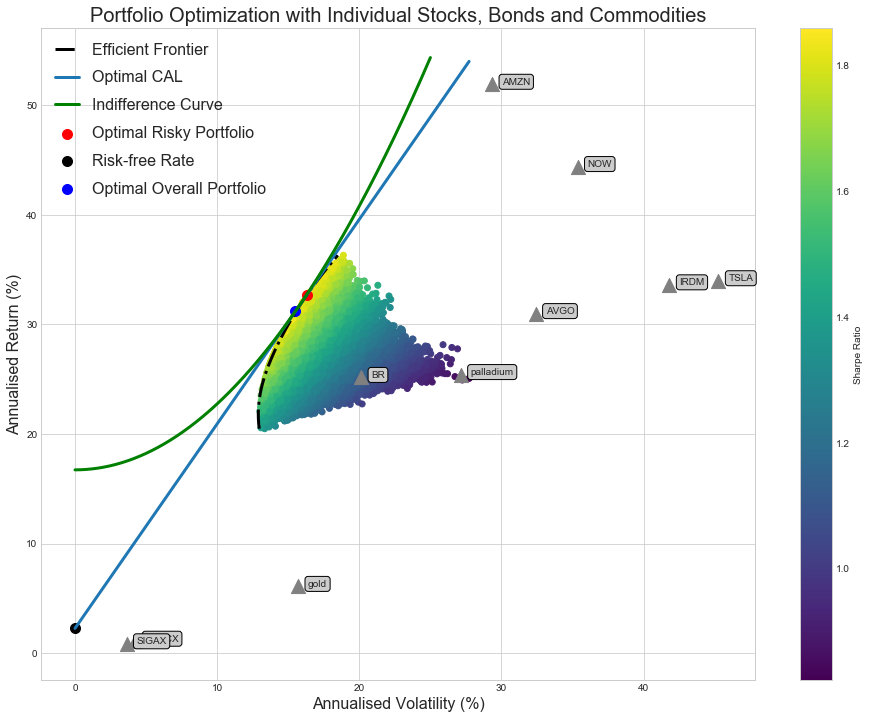

In [36]:
# Final graph that includes:
#     1. The random portfolios
#     2. The efficient frontier
#     3. The optimal risky Portfolio
#     4. The risk-free portfolio
#     5. The Optimal CAL
#     6. The individual instruments
#     7. The Indifference curve
#     8. The Optimal Overall Porfolio

fig, ax = plt.subplots(figsize=(16, 12))

# plot (1) the random portfolios
plt.scatter(df_ef['Volatility'], df_ef['Returns'], c=df_ef['Sharpe Ratio'], cmap='viridis')
cbar = plt.colorbar(label='Sharpe Ratio')

# plot (2) The Efficient Frontier
ax.plot([p['fun'] for p in efficient_portfolios], targets, linestyle='-.',lw=3, color='black', label='Efficient Frontier')

# plot (3) the Optimal Risky Portfolio
plt.scatter(opt_vol, opt_ret,c='red', s=100, label='Optimal Risky Portfolio') 

# plot (4) the risk-free portfolio
plt.scatter(0, rf,c='black', s=100, label='Risk-free Rate') 

# plot (5) the CAL
x = np.linspace(0, df_ef['Volatility'].max(), 1000)
y = x * (-optimal_sharpe_ratio['fun']) + rf
ax.plot(x,y, label='Optimal CAL', lw=3)

# plot (6) the individual instruments
vol = returns_daily.std() * np.sqrt(252)

ax.scatter(vol,returns_annual,marker='^',s=200,color='gray')
for i in range(len(assets)-1):
        ax.annotate(df.index.values[i], 
                   (vol[i],returns_annual[i]), 
                    xytext=(10,0), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.8"))

# plot (7) the optimal overall portfolio
plt.scatter(optimal_overall_volatility, optimal_overall_return,c='blue',s=100, label='Optimal Overall Portfolio') 

# plot (8) the Indifference Curve
ax.plot(utility_x, utility_y, label='Indifference Curve', lw=3,color='green')
    

# title, axes and legend
ax.set_title('Portfolio Optimization with Individual Stocks, Bonds and Commodities', fontsize=20)
ax.set_xlabel('Annualised Volatility (%)', fontsize=16)
ax.set_ylabel('Annualised Return (%)', fontsize=16)
ax.legend(labelspacing=0.8,shadow=True, handlelength=1.5, fontsize=16)

We have calculated the desired allocation between the risky portfolio and the risk-free assets. Therofore we can derive the risk, return and performance measures of the optimal portfolio:

In [37]:
ret_overall = rf + optimal_z * (opt_ret - rf)

vol_overall = optimal_z * opt_vol

beta_overall = optimal_z * opt_beta

alpha_opt = opt_ret - (rf + opt_beta*(market_returns-rf))

alpha_overall = ret_overall - (rf + beta_overall*(market_returns-rf))

sharpe_o = (ret_overall - rf)/vol_overall

print(ret_overall.round(4))
print(vol_overall.round(4))
print(beta_overall.round(4))
print(alpha_opt.round(4))
print(sharpe_o.round(4))
print(alpha_overall.round(4))

31.1941
15.5026
0.8613
22.2486
1.8658
21.1362


Now we calculate the Holding Period Returns for the Quarter:

In [38]:
d = datetime.datetime(2020, 1, 14)
from_date = str(d.day) + '/' + str(d.month) + '/' + str(d.year)

d = datetime.datetime.now()
to_date = str(d.day) + '/' + str(d.month) + '/' + str(d.year)

s1 = investpy.stocks.get_stock_historical_data(stock=stocks[0], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s2 = investpy.stocks.get_stock_historical_data(stock=stocks[1], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s3 = investpy.stocks.get_stock_historical_data(stock=stocks[2], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s4 = investpy.stocks.get_stock_historical_data(stock=stocks[3], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s5 = investpy.stocks.get_stock_historical_data(stock=stocks[4], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
s6 = investpy.stocks.get_stock_historical_data(stock=stocks[5], country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

benchmark = investpy.indices.get_index_historical_data(index='S&P 500', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

b1 = investpy.funds.get_fund_historical_data(fund='Payden Corporate Bond Fund', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']
b2 = investpy.funds.get_fund_historical_data(fund='Western Asset Corporate Bond Fund Class A', country='united states', from_date=from_date, to_date=to_date, interval='Daily')['Close']

c1 = investpy.commodities.get_commodity_historical_data(commodity=commodities[0],from_date=from_date, to_date=to_date, interval='Daily')['Close']
c2 = investpy.commodities.get_commodity_historical_data(commodity=commodities[1],from_date=from_date, to_date=to_date, interval='Daily')['Close']

# Place the DataFrames side by side
s = pd.concat([s1, s2, s3, s4, s5, s6], axis=1)
s.columns = stocks

b = pd.concat([b1, b2], axis=1)
b.columns = bonds

c = pd.concat([c1, c2, benchmark], axis=1)
c.columns = commodities + sp500

data = pd.concat([s, b, c], axis=1)
data = data.dropna()
data.head()

rf_period = 1.2 / 4 # this is a 3-month period, therefore we divide the constant rate by 4

period_returns = data.pct_change(periods=len(data['AVGO'].tolist())-1)*100

assets_ret = period_returns.iloc[-1][:-1].tolist()

market_ret = period_returns.iloc[-1][-1].tolist()

print(assets_ret)
print(market_ret)

risky_portfolio_return = np.dot(opt_weights, assets_ret)

overall_portfolio_return = rf_period + optimal_z*(risky_portfolio_return - rf_period)

print(risky_portfolio_return)

print(overall_portfolio_return)

[-37.627360633396066, -15.522388059701498, -20.521638905413443, -1.2490371448134252, -24.506387921022068, -29.141295862607343, -11.176968670618127, -15.793528505392917, -4.274937133277468, -28.807752774714313]
-29.795470813091086
-13.846176559933408
-13.138867731936736
